# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.duplicated().sum()

0

In [6]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
# fill missing values

df_reviews['average_rating'].fillna(df_reviews['average_rating'].median(), inplace=True)
df_reviews['votes'].fillna(df_reviews['votes'].median(), inplace=True)

df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

## EDA

Let's check the number of movies and reviews over years.

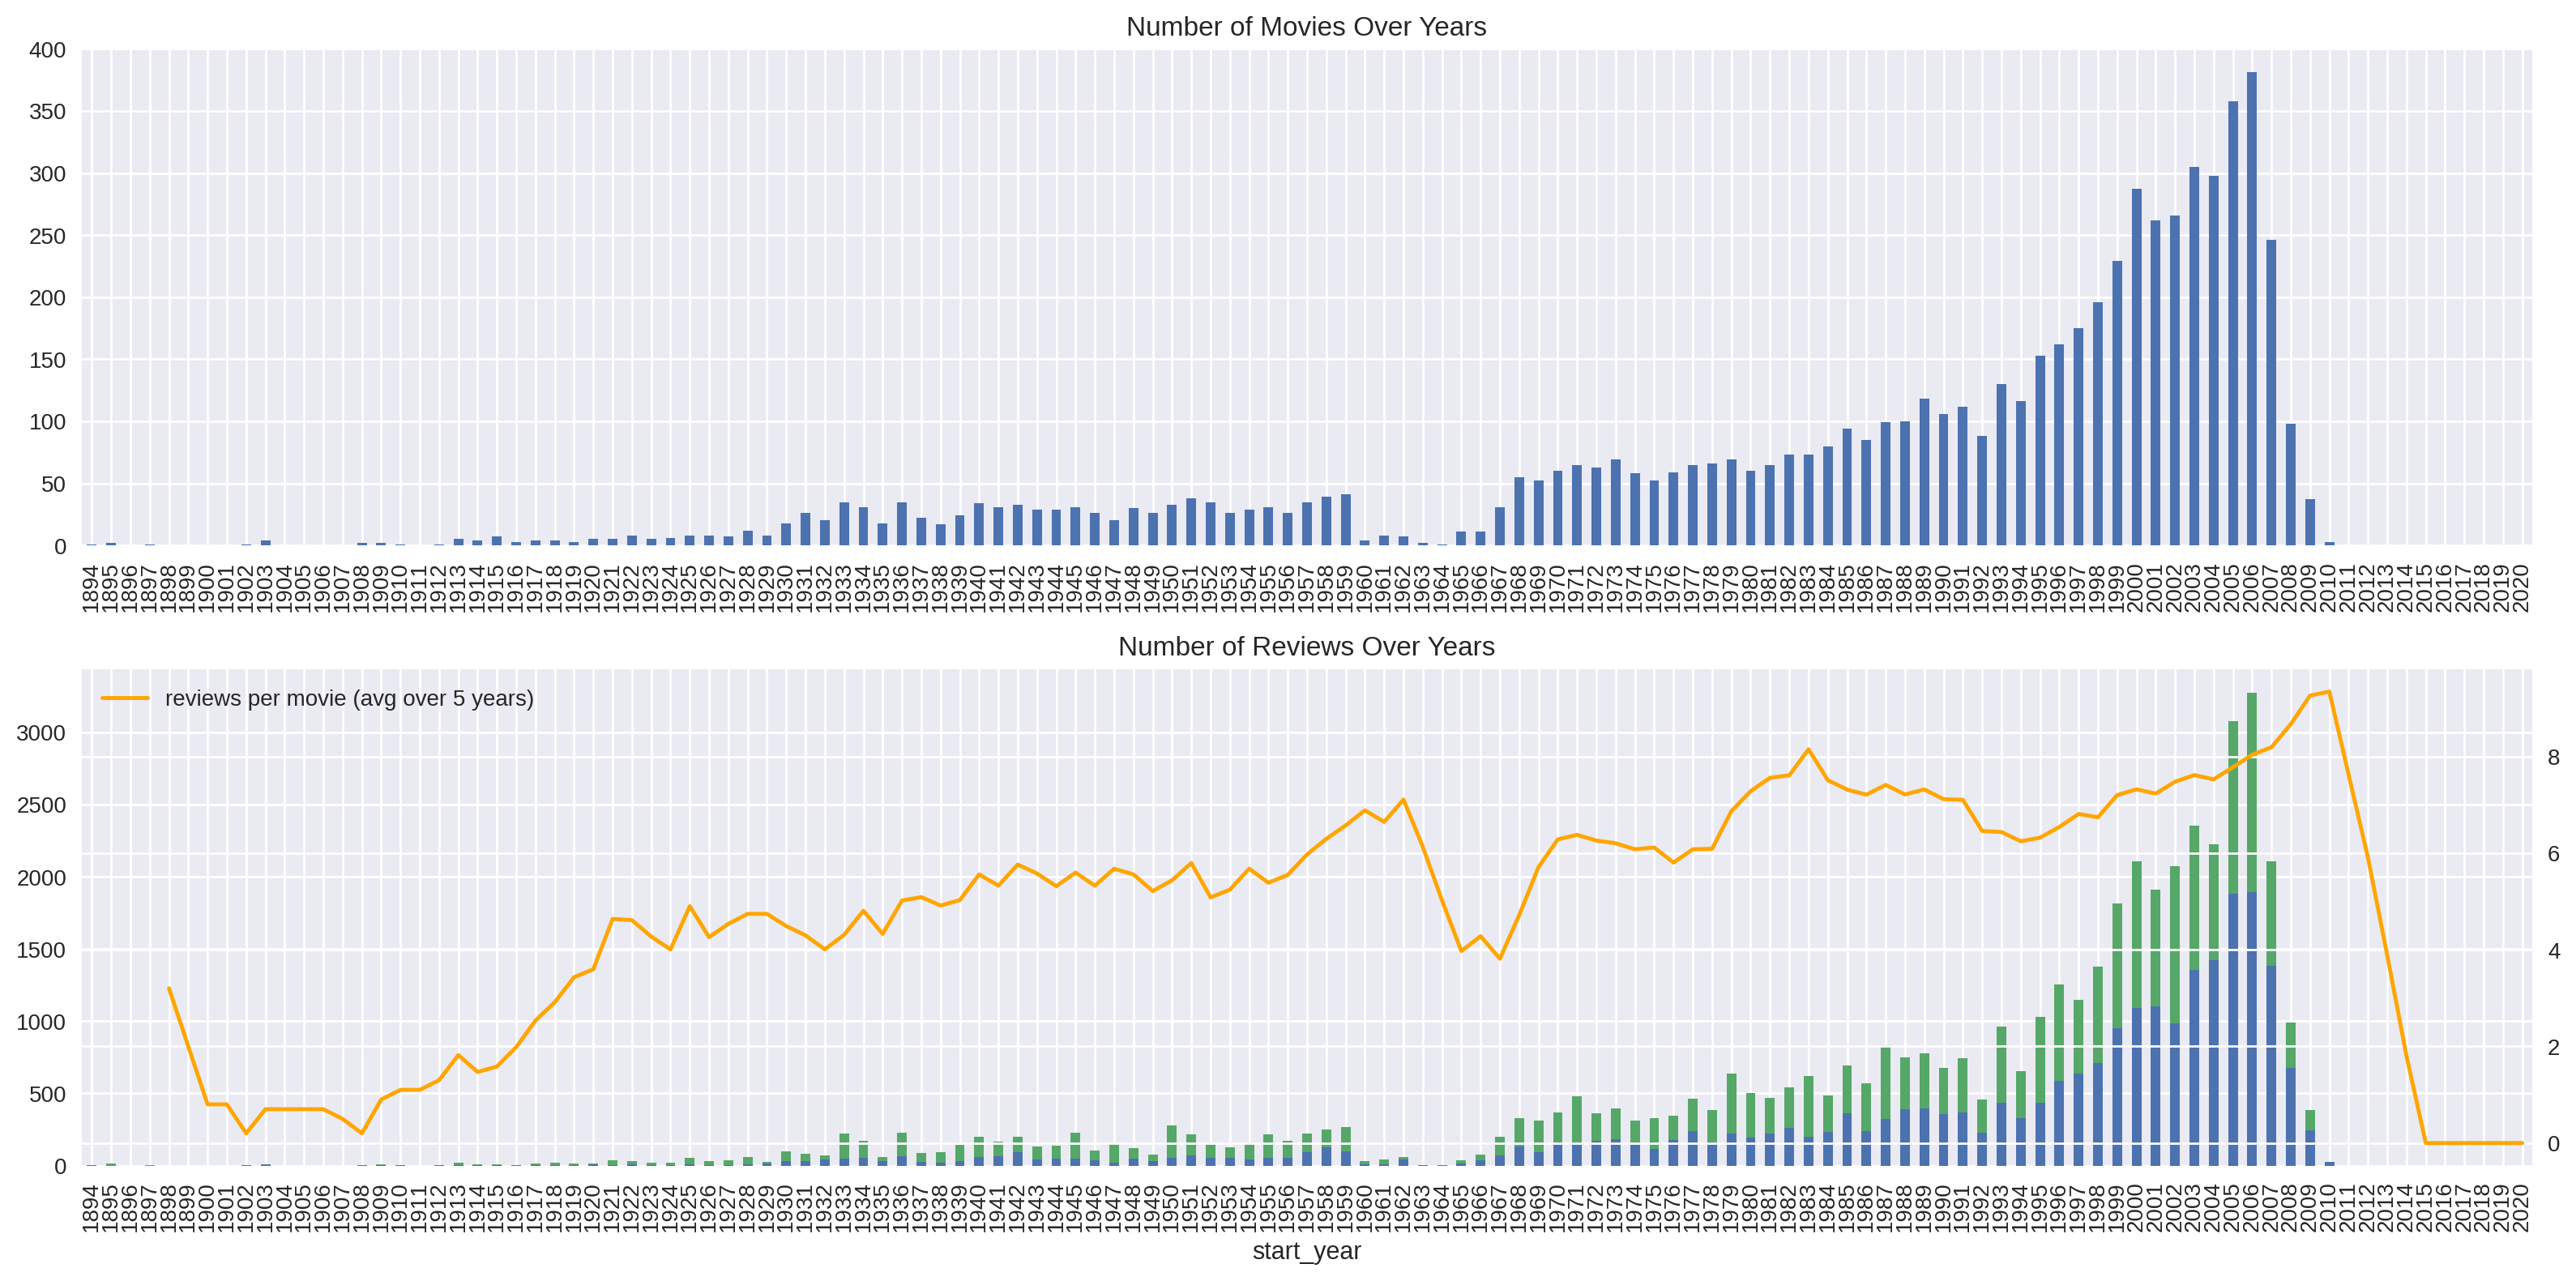

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The film industry has experienced remarkable growth over the past century, with rapid acceleration in recent decades. Over time, the number of reviews per movie has generally risen, indicating increased public engagement with cinema or the proliferation of review platforms. Both graphs reveal a noticeable dip in 2006, likely linked to the global recession or another significant event. The digital era (post-2000) appears to have profoundly influenced both movie production and review volumes, potentially driven by advancements in filmmaking technology and the rise of online review platforms.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

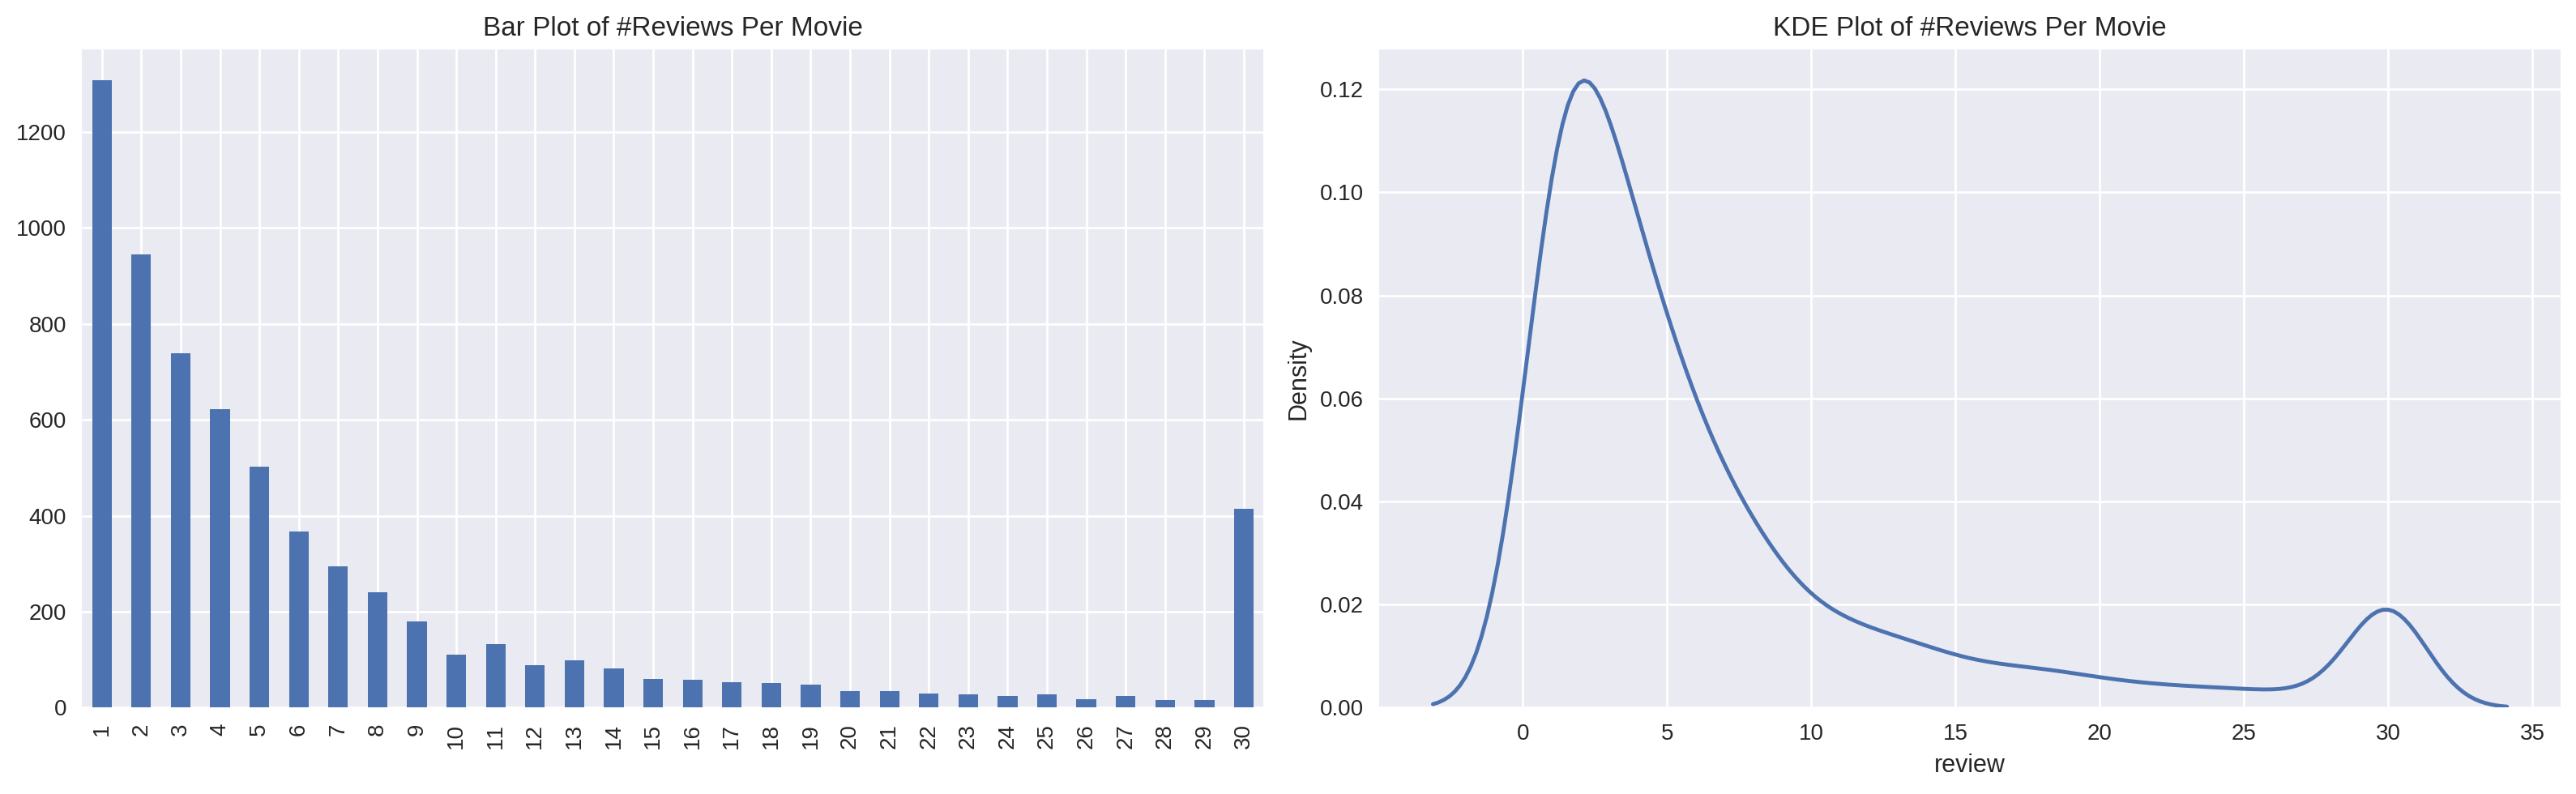

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The distribution is highly skewed, with the majority of movies receiving very few reviews (1-3). However, there is a long tail where a small number of movies attract a large volume of reviews. The secondary peak observed in the KDE plot indicates the potential existence of two distinct groups of movies: those that receive minimal attention (few reviews) and those that achieve substantial popularity (many reviews).

The bar plot and KDE plot work well together to provide insights, with the bar plot highlighting the exact counts and the KDE plot offering a smoothed view of the distribution.

This pattern suggests that while most movies struggle to garner reviews, a select few manage to capture significant audience engagement. Factors such as marketing efforts, critical reception, or viral popularity likely contribute to these disparities in review counts.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

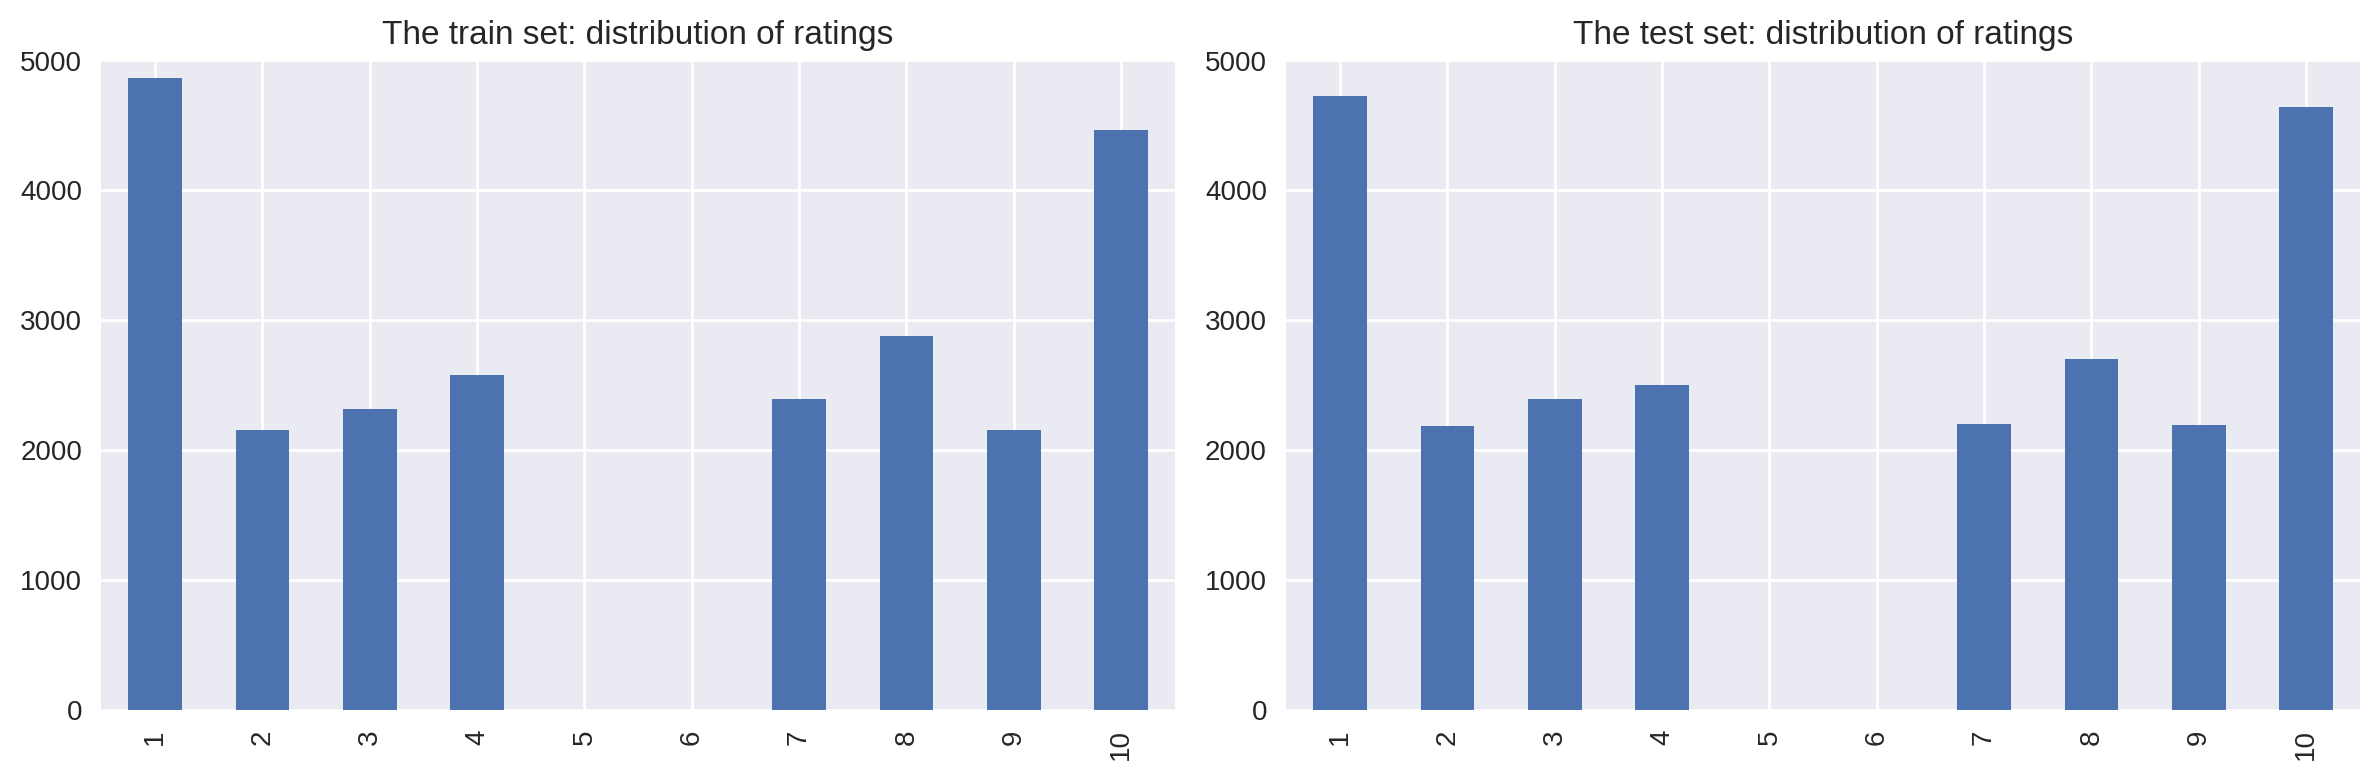

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Both sets exhibit a strong U-shaped distribution, where extreme ratings (1 and 10) dominate over middle ratings. The similarity in distributions between the train and test sets indicates effective data splitting, ensuring that the overall distribution is preserved across both.

The lack of data for ratings 5 and 6 is particularly notable and may point to:

A rating system that omits these middle values.
Data preprocessing that consolidated ratings into broader categories.
A general tendency among users to avoid neutral ratings.
Additionally, there is a slight skew toward positive ratings (7-10) compared to negative ratings (2-4) in both sets. The high prevalence of 1-star ratings might reflect a significant number of very dissatisfied users or potentially spam or bot-generated reviews.

This pattern highlights a common trend in rating systems, where users often gravitate toward extremes rather than moderate evaluations. The consistency between the train and test sets is essential for building a reliable predictive model.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


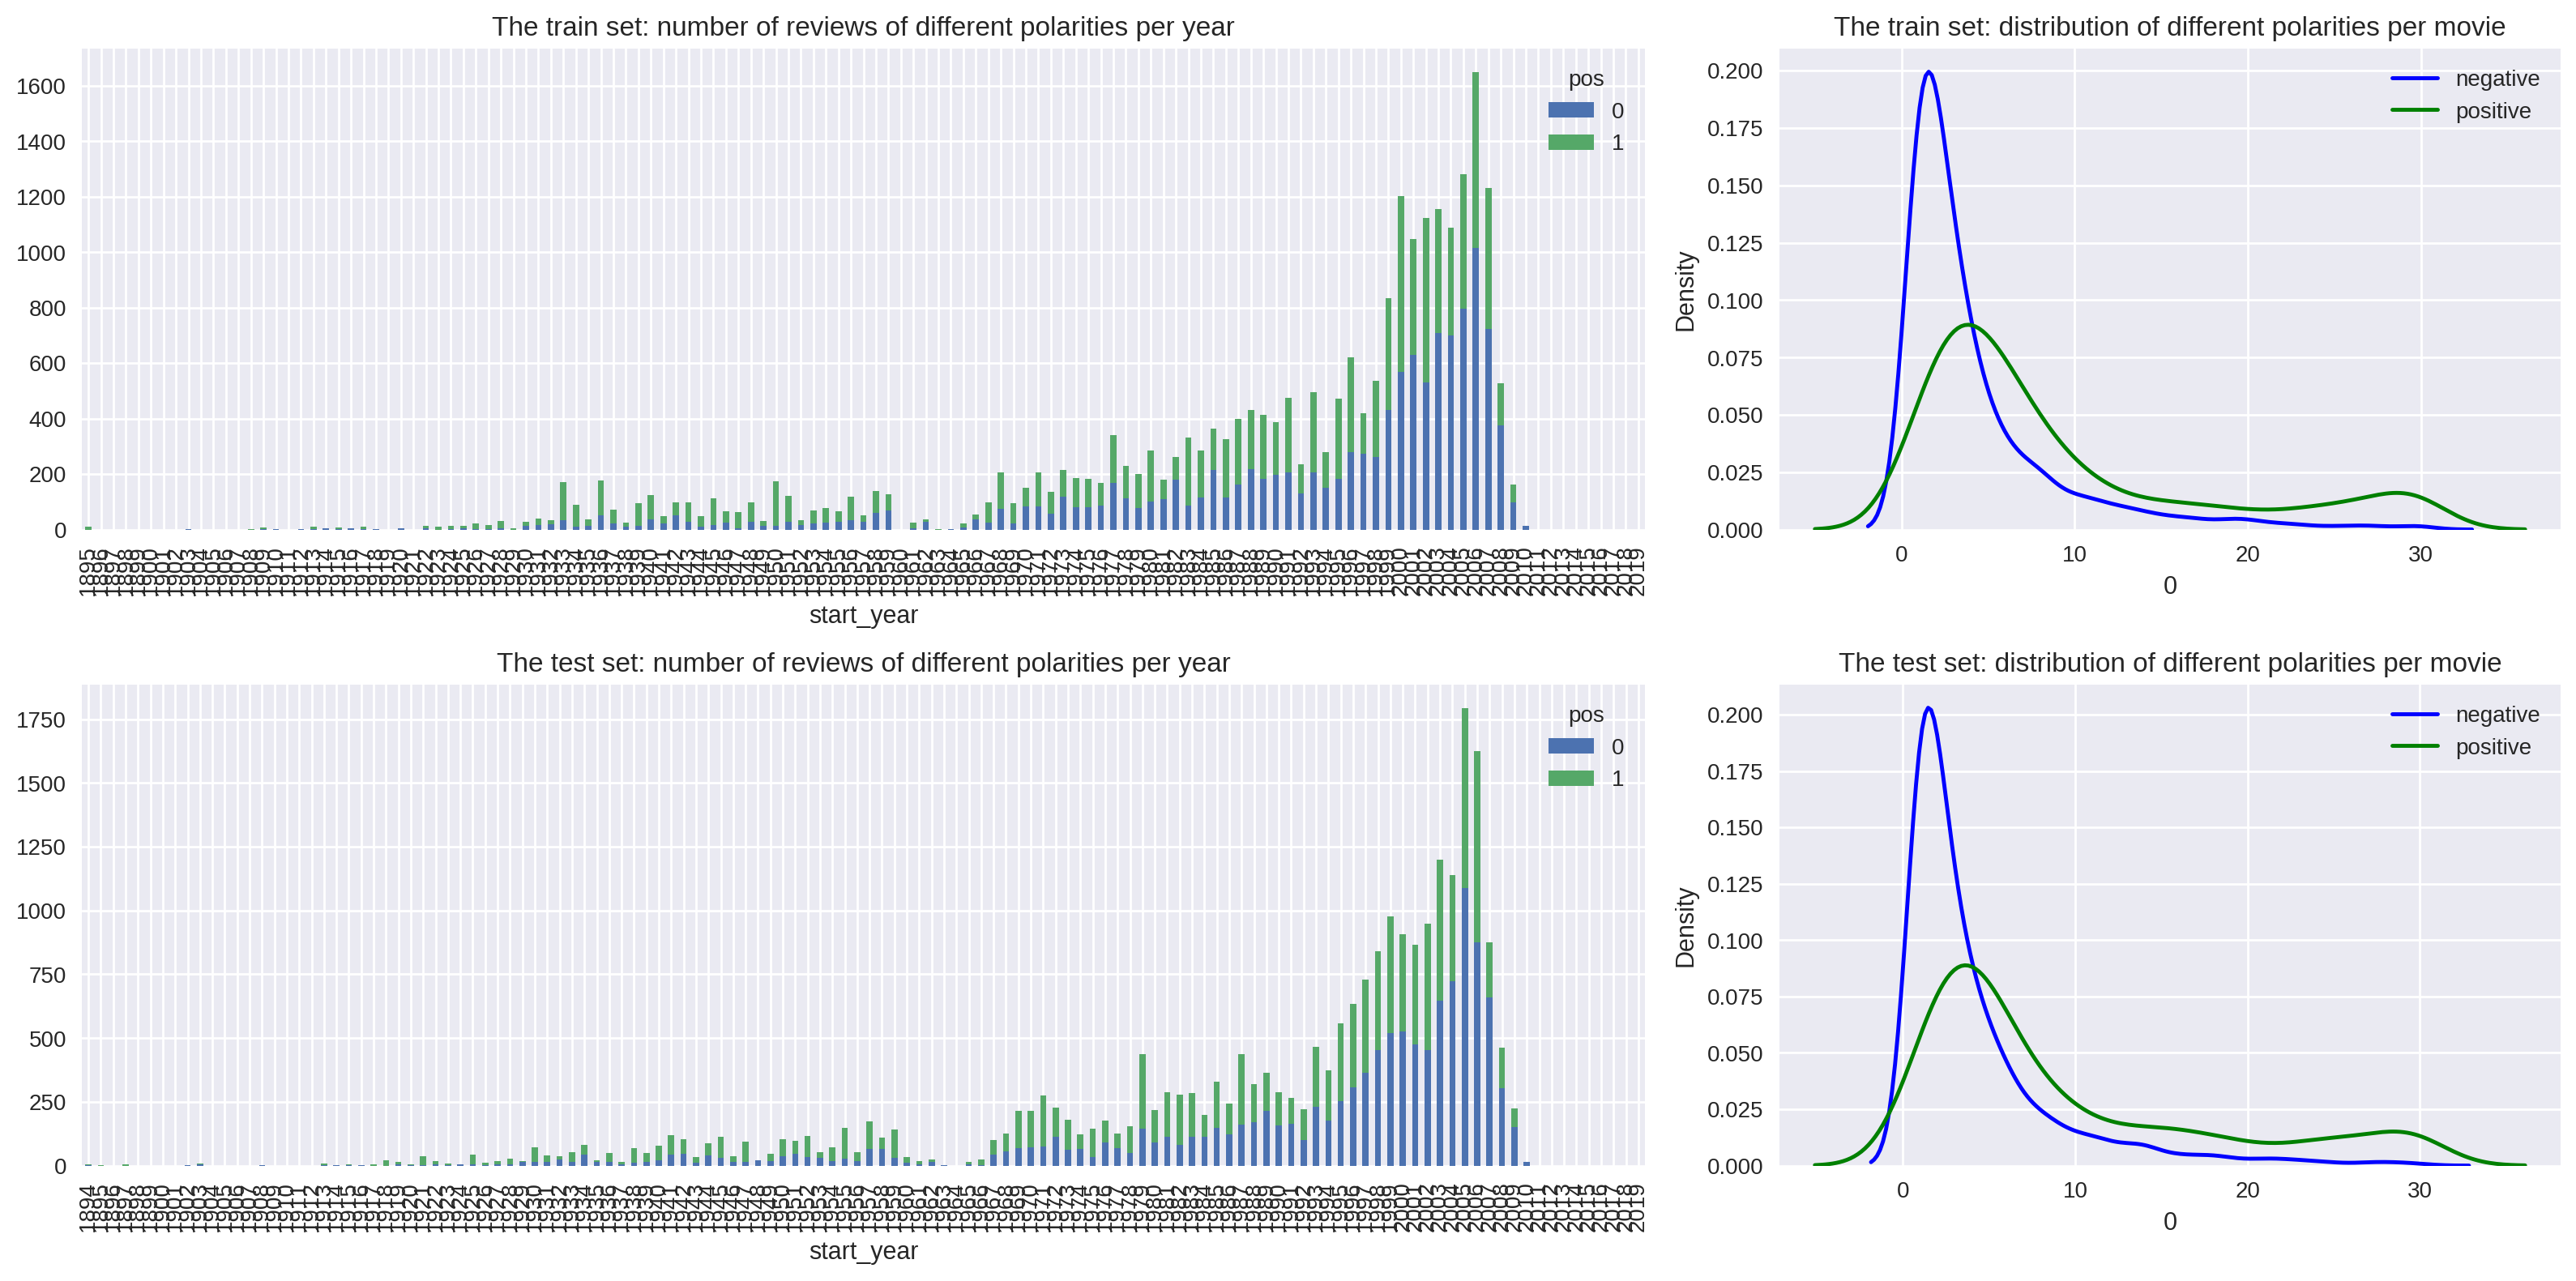

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Both sets exhibit a strong U-shaped distribution, where extreme ratings (1 and 10) dominate over middle ratings. The similarity in distributions between the train and test sets indicates effective data splitting, ensuring that the overall distribution is preserved across both.

The lack of data for ratings 5 and 6 is particularly notable and may point to:

A rating system that omits these middle values.
Data preprocessing that consolidated ratings into broader categories.
A general tendency among users to avoid neutral ratings.
Additionally, there is a slight skew toward positive ratings (7-10) compared to negative ratings (2-4) in both sets. The high prevalence of 1-star ratings might reflect a significant number of very dissatisfied users or potentially spam or bot-generated reviews.

This pattern highlights a common trend in rating systems, where users often gravitate toward extremes rather than moderate evaluations. The consistency between the train and test sets is essential for building a reliable predictive model.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
import re

In [15]:
def normalize_text(text):
    text= text.lower() # lowercase
    text = re.sub(r'\d+', '', text) #digit removal
    text = re.sub(r'\s+', ' ', text) # Whitespace removal
    text = re.sub(r'[^\w\s]', '', text) #punctuation mark removal
    return text

In [16]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [18]:
import sys
import gc

# Check memory usage of df_reviews
print(f"Memory usage of df_reviews: {sys.getsizeof(df_reviews)} bytes")

Memory usage of df_reviews: 165308747 bytes


In [19]:
# Delete df_reviews to free up memory
del df_reviews

# Force garbage collection to free up memory
gc.collect()

6

In [20]:
# Drop the target column ('pos') and the review column ('review') from the training and test sets to get features
df_reviews_train = df_reviews_train.drop(columns=['pos', 'review'])
df_reviews_test = df_reviews_test.drop(columns=['pos', 'review'])

## Working with models

### Model 0 - Constant

In [21]:
from sklearn.dummy import DummyClassifier

In [22]:
#initiate the dummy classifier
model_0  = DummyClassifier(strategy='constant', constant=1)

In [23]:
#train the model
model_0.fit(df_reviews_train, train_target)

DummyClassifier(constant=1, strategy='constant')

In [24]:
#predict on the training on the test dataset
train_predict = model_0.predict(df_reviews_train)
test_predict = model_0.predict(df_reviews_test)

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


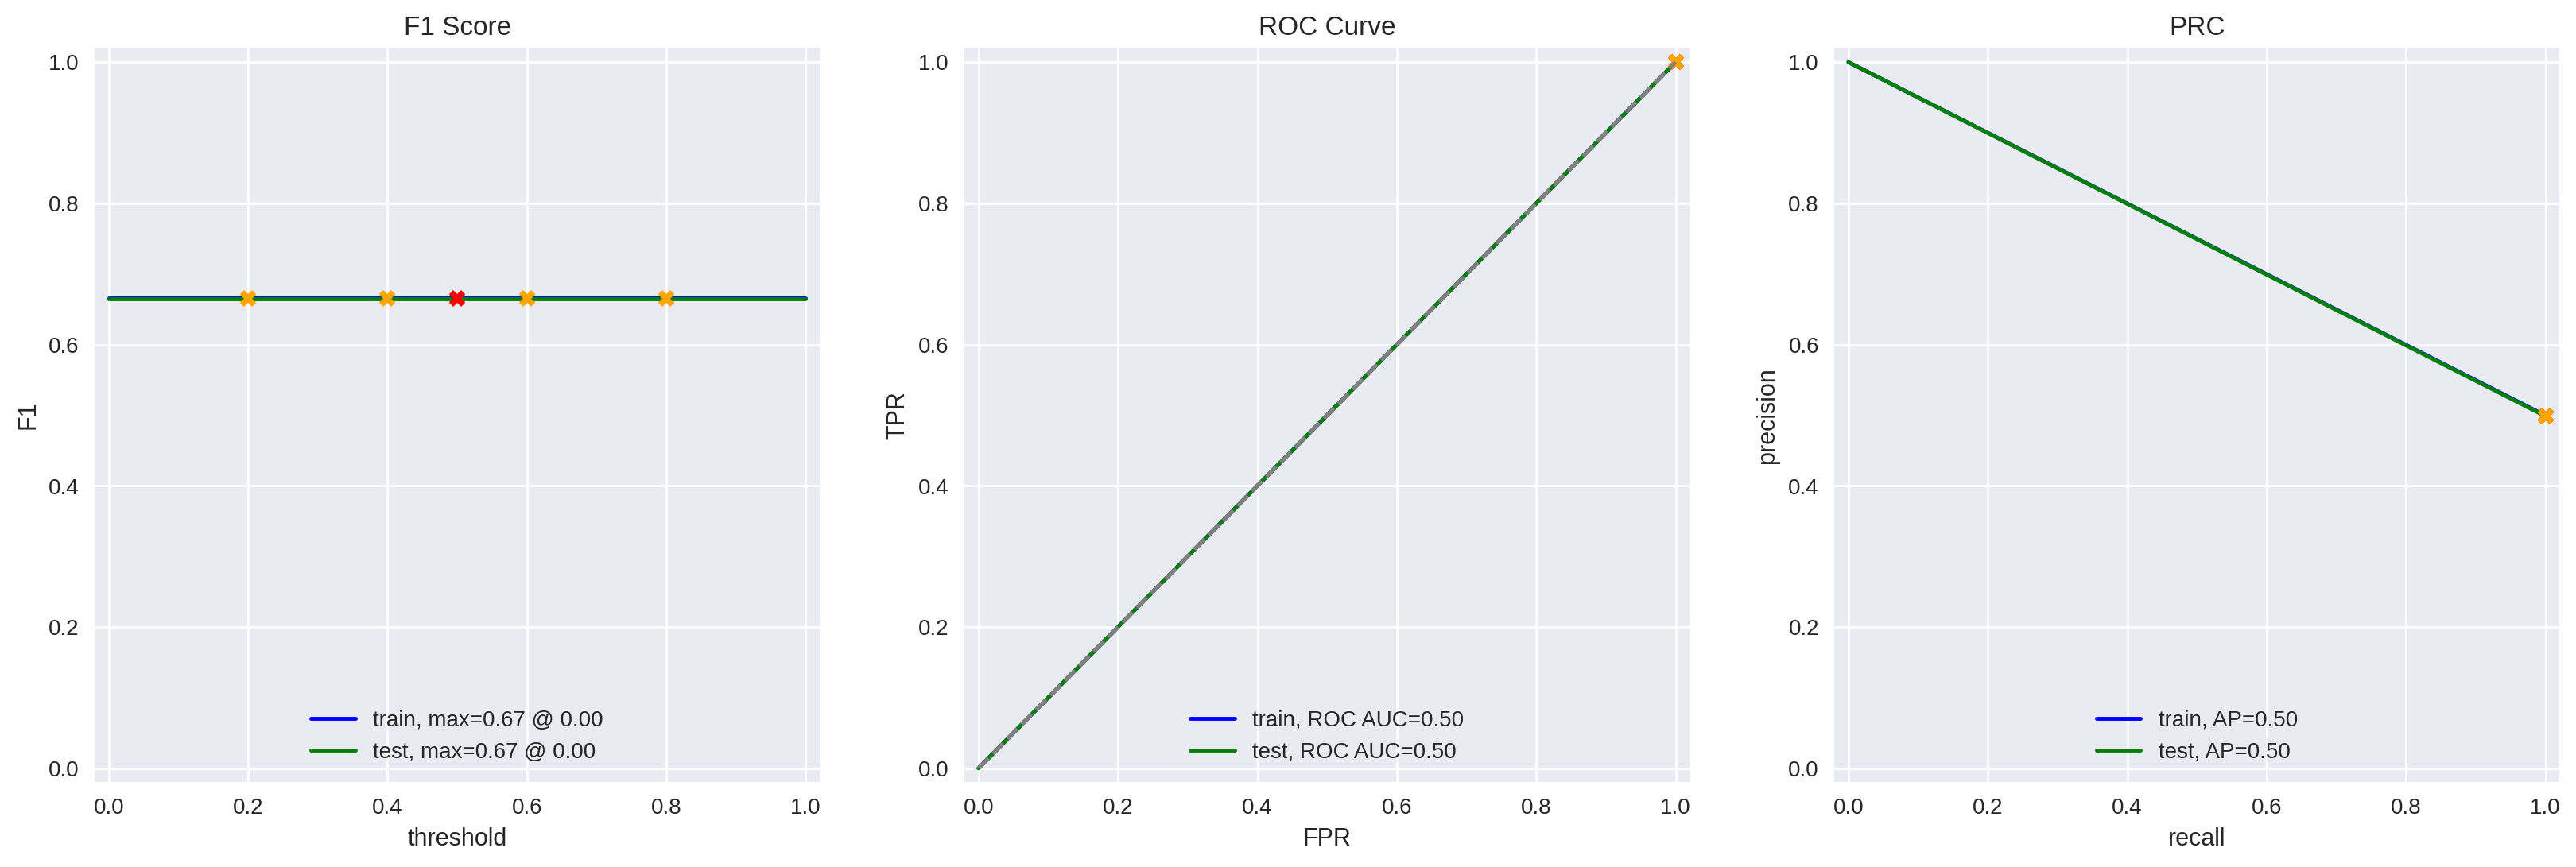

In [25]:
evaluate_model(model_0, df_reviews_train, train_target, df_reviews_test, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [26]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [27]:
#download nltk words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
#define stop words
stop_words = stopwords.words('english')

#create TF IDF vectorixzer
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words, lowercase=True, use_idf=True, ngram_range=(1,2))

#transform the normalizrf review text to tfidf vectors
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

train_features_1.shape

(23796, 1853270)

In [29]:
test_features_1.shape

(23535, 1853270)

In [30]:
#initiate LR
model_1 = LogisticRegression(max_iter=1000)

#Train the model
model_1.fit(train_features_1, train_target)

# predic the training and test datasets
train_predict_1 = model_1.predict(train_features_1)
test_predict_1 = model_1.predict(test_features_1)

          train  test
Accuracy   0.96  0.88
F1         0.96  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95


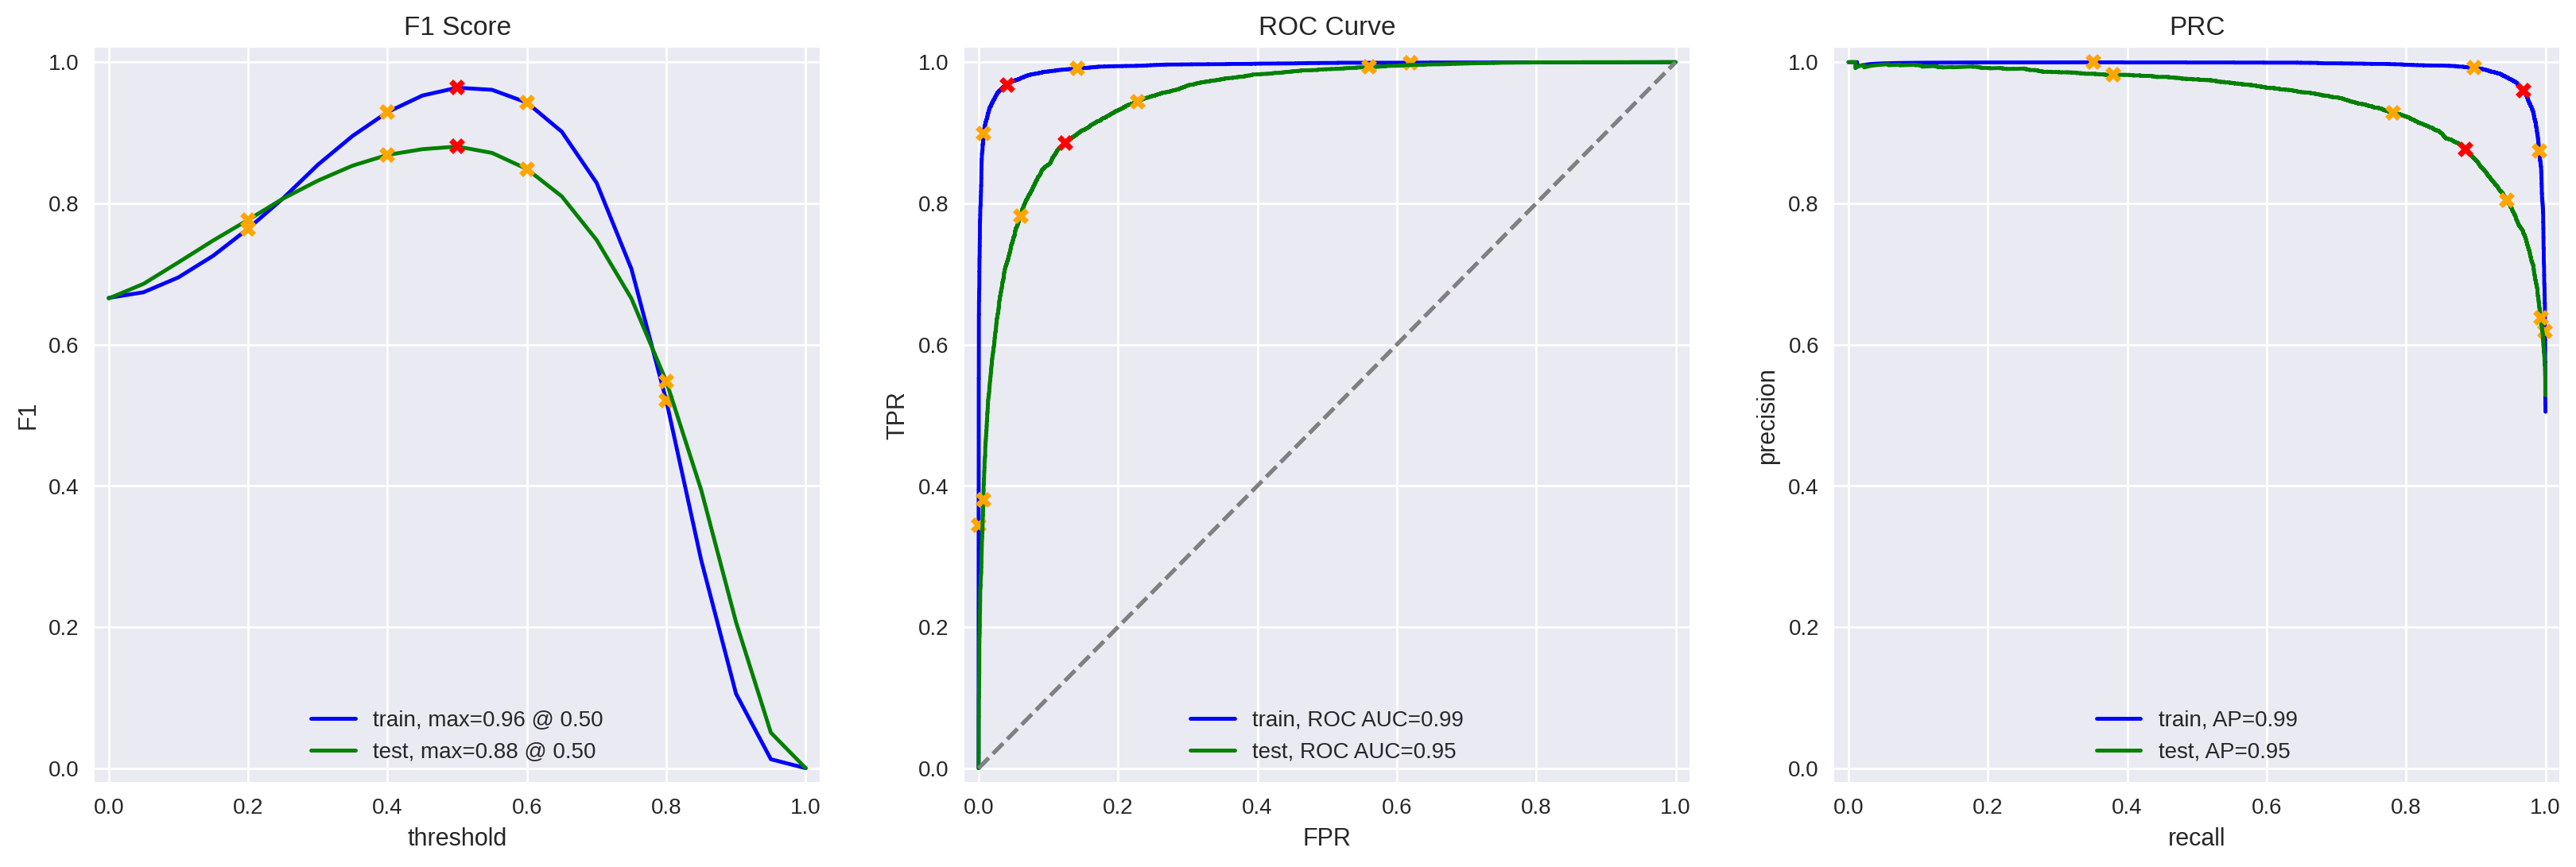

In [31]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [32]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [34]:
# Apply preprocessing to the reviews
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Set up TF-IDF Vectorizer with a valid min_df value
tfidfv_2 = TfidfVectorizer(min_df=1, max_features=10_000, strip_accents='unicode', lowercase=True,
                           analyzer='word', ngram_range=(1, 1), use_idf=True, smooth_idf=True,
                           sublinear_tf=True, stop_words='english')

# Transform the spaCy preprocessed review text to TF-IDF vectors
features_train_spacy = tfidfv_2.fit_transform(df_reviews_train['review_spacy'].values)
features_test_spacy = tfidfv_2.transform(df_reviews_test['review_spacy'].values)


In [35]:
# Initiate Logistic Regression
model_2 = LogisticRegression(max_iter=1000)

# Train the model
model_2.fit(features_train_spacy, train_target)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


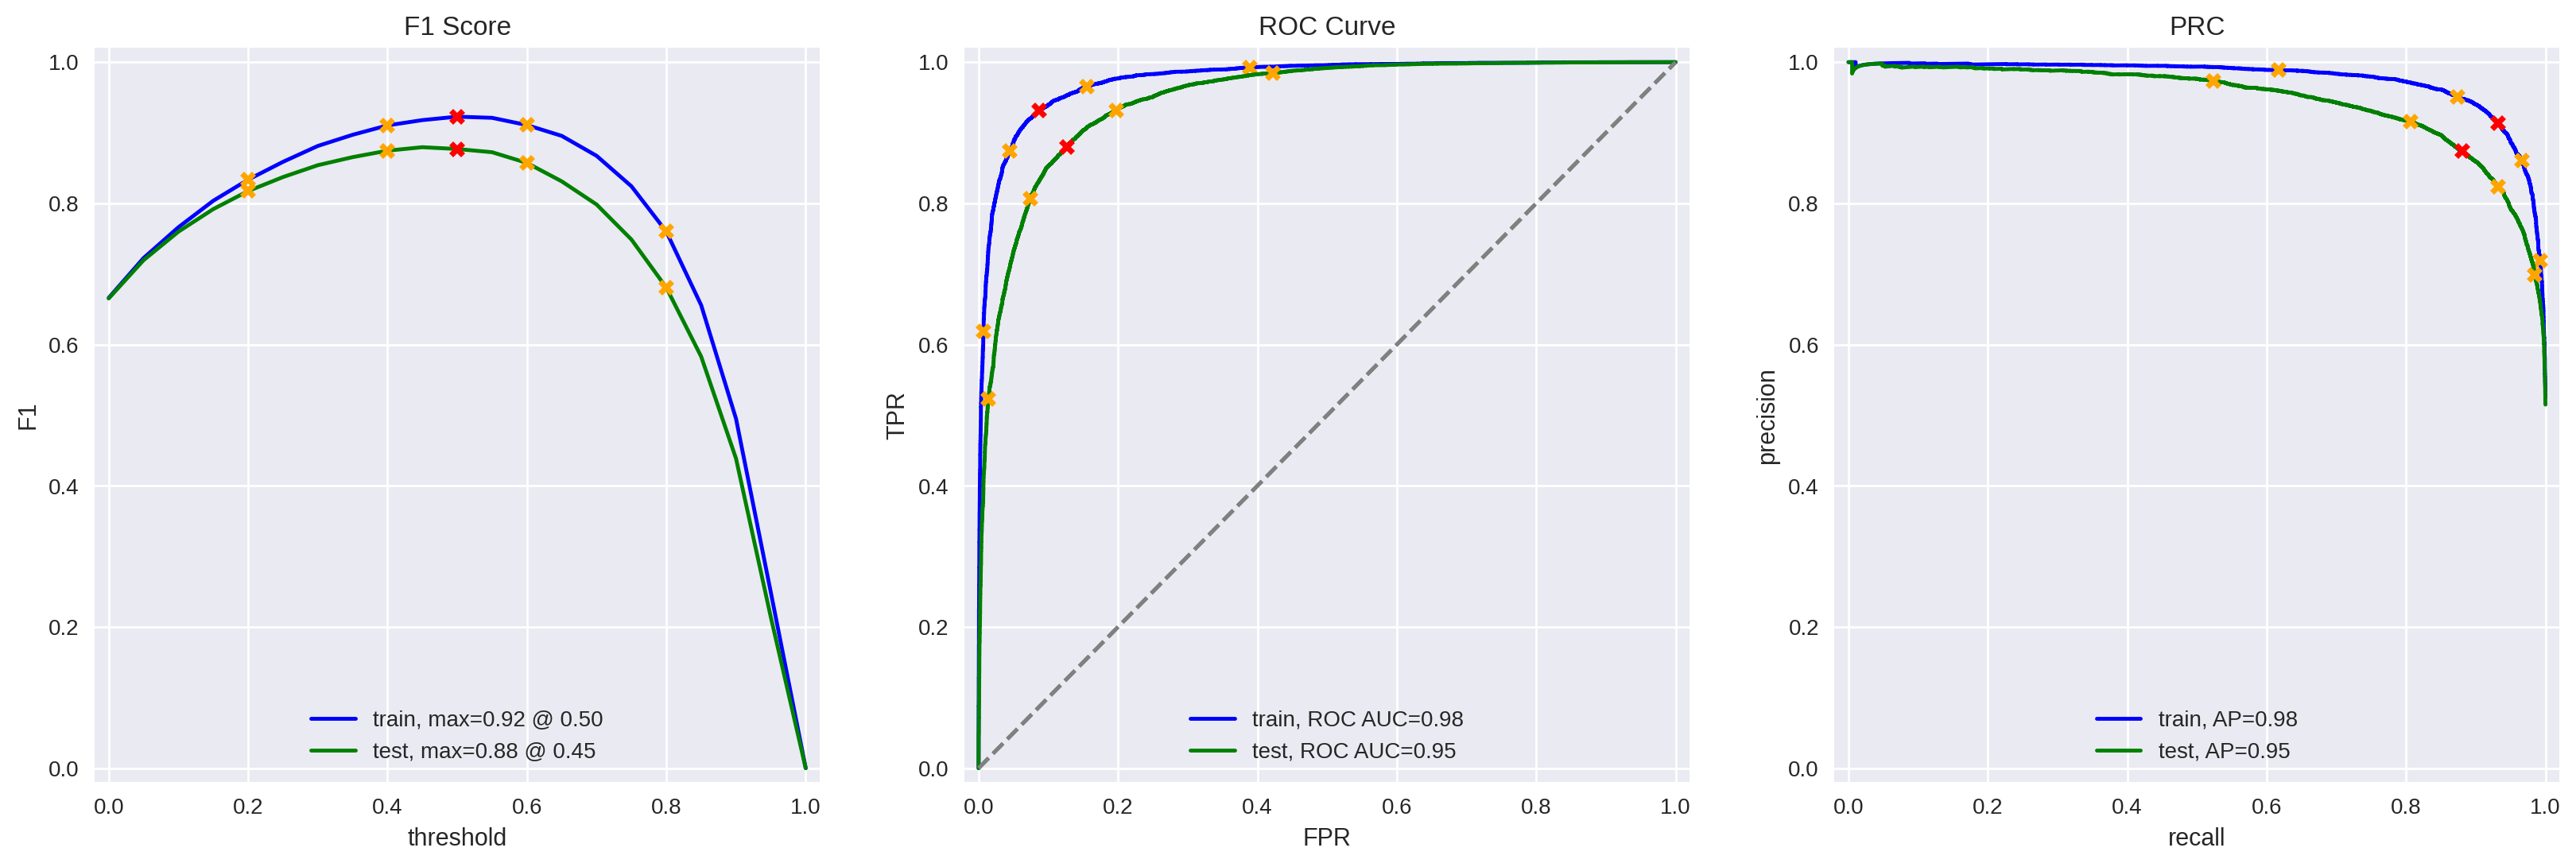

In [36]:
#evaluate
evaluate_model(model_2, features_train_spacy, train_target, features_test_spacy, test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [37]:
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
# load spacy's small english model
# nlp already defined
# initiate model
model_3 = lgb.LGBMClassifier()

# train the model
model_3.fit(features_train_spacy, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


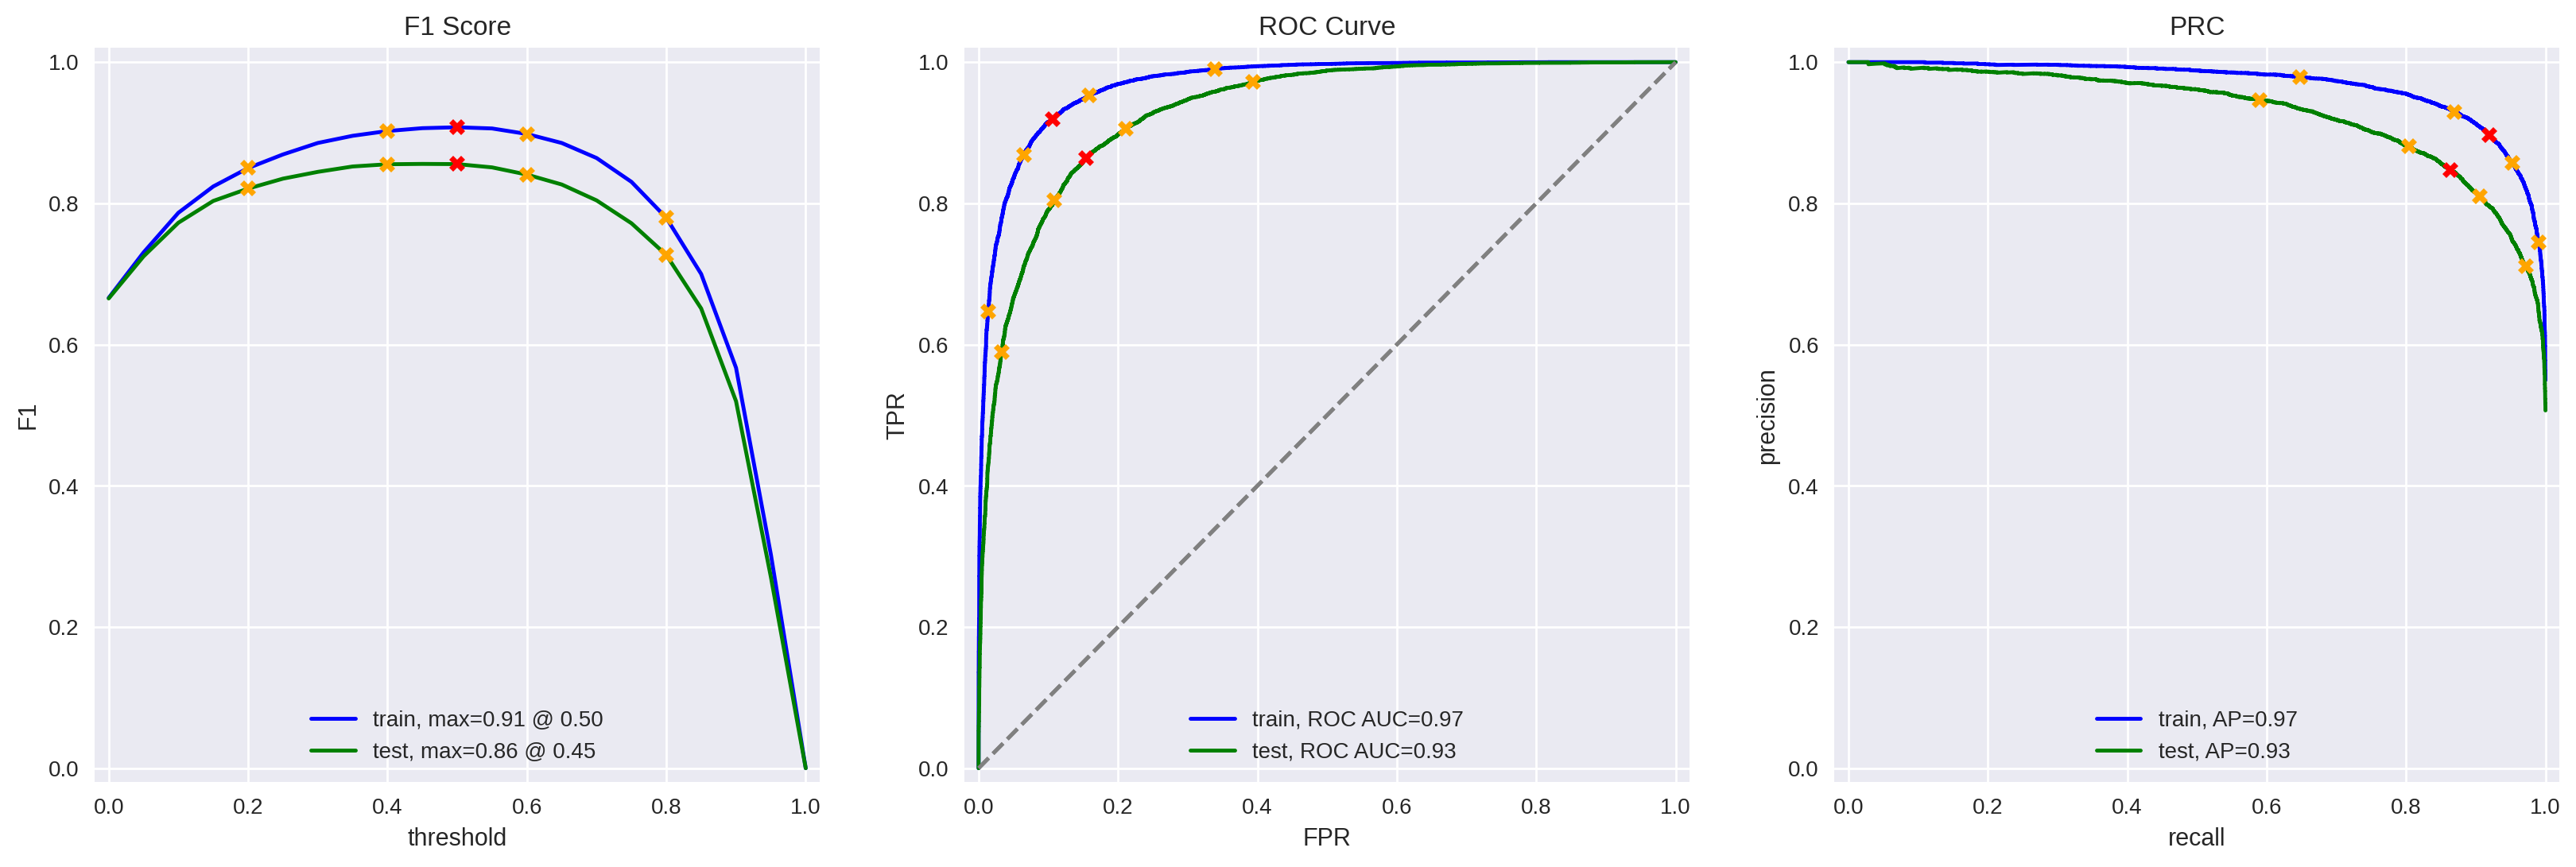

In [39]:
# Evaluate the model
evaluate_model(model_3, features_train_spacy, train_target, features_test_spacy, test_target)

###  Model 9 - BERT

In [40]:
import torch
import transformers
from transformers import BertForSequenceClassification

In [41]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=16, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(encoding['input_ids'].flatten())
        attention_mask_list.append(encoding['attention_mask'].flatten())
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.stack(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.stack(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

# on test
test_features_4 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

Using the cpu device.


  0%|          | 0/1488 [00:00<?, ?it/s]

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

<div class="alert alert-info"> <b>Student сomments:</b>  This keeps crashing. after 2 hours of processing. it only got to 42 out of 1488.  .</div>

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Define the text normalization logic
def normalize_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove digits and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    return text


my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)# <put here the same normalization logic as for the main dataset>

my_reviews

### Model 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions